In [ ]:
pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 313M/331M [00:03<00:00, 49.0MB/s]
100% 331M/331M [00:03<00:00, 87.8MB/s]


In [ ]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
!ls

crop_part1  sample_data  UTKFace  utkface_aligned_cropped  utkface-new.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp utkface-new.zip /content/drive/MyDrive/

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [ ]:
import os

print(os.listdir("."))


['.config', 'utkface-new.zip', 'utkface_aligned_cropped', 'crop_part1', 'UTKFace', 'drive', 'sample_data']


In [ ]:
import os
from tqdm import tqdm

# Set the correct path to the UTKFace folder
BASE_DIR = './UTKFace'

# Verify that the directory exists
if not os.path.exists(BASE_DIR):
    raise FileNotFoundError(f"The directory {BASE_DIR} does not exist. Please check the path.")

# Initialize lists for storing paths and labels
image_paths = []
age_labels = []
gender_labels = []

# Iterate through the files in the directory
for filename in tqdm(os.listdir(BASE_DIR)):
    # Construct the full path to the image
    image_path = os.path.join(BASE_DIR, filename)

    # Split the filename to extract labels (assuming the format is age_gender_ethnicity...)
    temp = filename.split('_')

    try:
        # Extract age and gender from the filename
        age = int(temp[0])  # First element is age
        gender = int(temp[1])  # Second element is gender
        # Append the data to respective lists
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    except (IndexError, ValueError) as e:
        print(f"Skipping file {filename} due to unexpected format: {e}")

# Verify the loaded data
print(f"Total images: {len(image_paths)}")
print(f"Sample image path: {image_paths[0]}")
print(f"Sample age: {age_labels[0]}, Sample gender: {gender_labels[0]}")


100%|██████████| 23708/23708 [00:00<00:00, 385317.72it/s]

Total images: 23708
Sample image path: ./UTKFace/30_1_1_20170113011704335.jpg.chip.jpg
Sample age: 30, Sample gender: 1


In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,./UTKFace/30_1_1_20170113011704335.jpg.chip.jpg,30,1
1,./UTKFace/70_0_0_20170120221807750.jpg.chip.jpg,70,0
2,./UTKFace/53_1_0_20170117161107736.jpg.chip.jpg,53,1
3,./UTKFace/28_1_0_20170105162423130.jpg.chip.jpg,28,1
4,./UTKFace/24_0_4_20170117145152514.jpg.chip.jpg,24,0


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

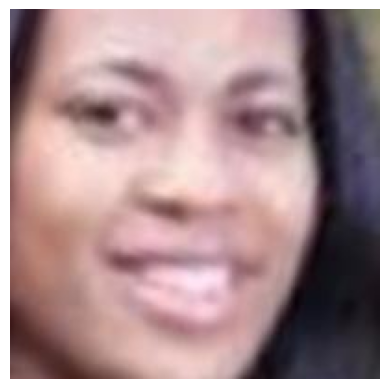

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

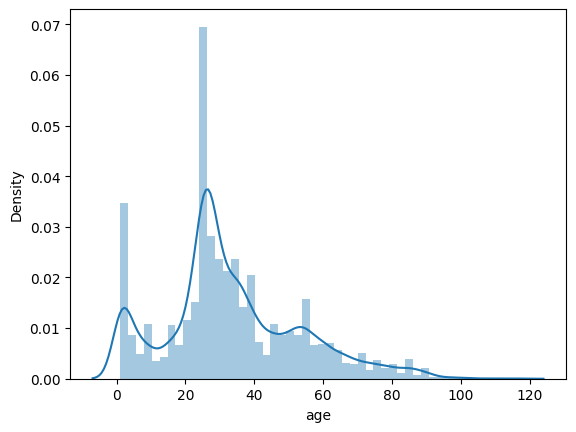

In [ ]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

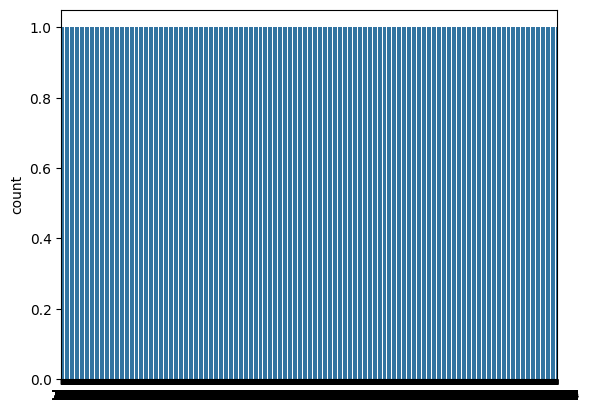

In [ ]:
sns.countplot(df['gender'])

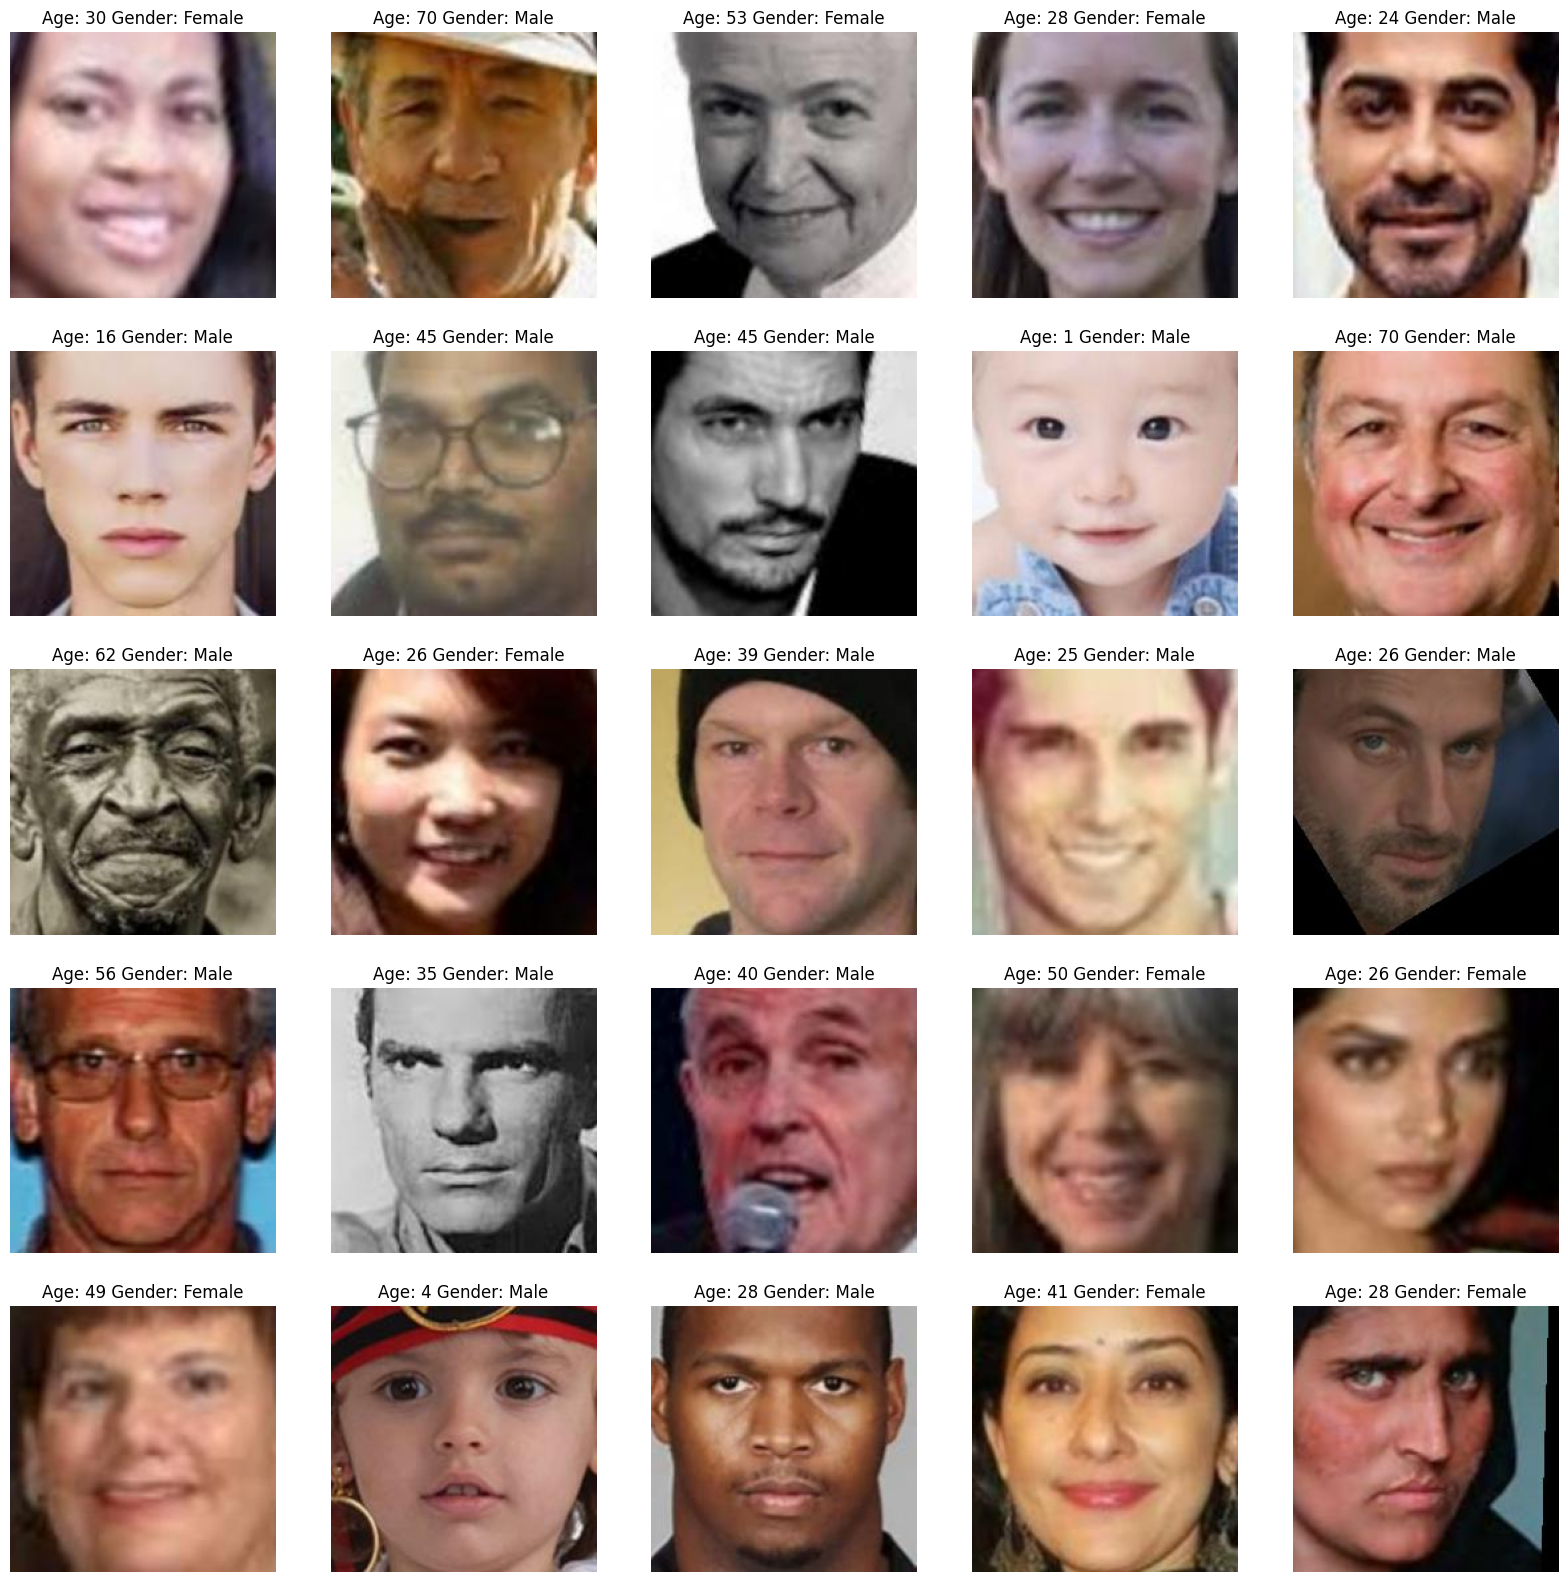

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
from tensorflow.keras.utils import load_img
from PIL import Image
import numpy as np
from tqdm import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        # Load the image
        img = load_img(image, color_mode='grayscale')  # Load as grayscale
        # Resize the image (use LANCZOS instead of ANTIALIAS)
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        # Convert the image to a NumPy array
        img = np.array(img)
        # Append the feature
        features.append(img)
    return np.array(features)


In [ ]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:32<00:00, 721.13it/s]


In [ ]:
X.shape

(23708, 128, 128)

In [ ]:
# normalize the images
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

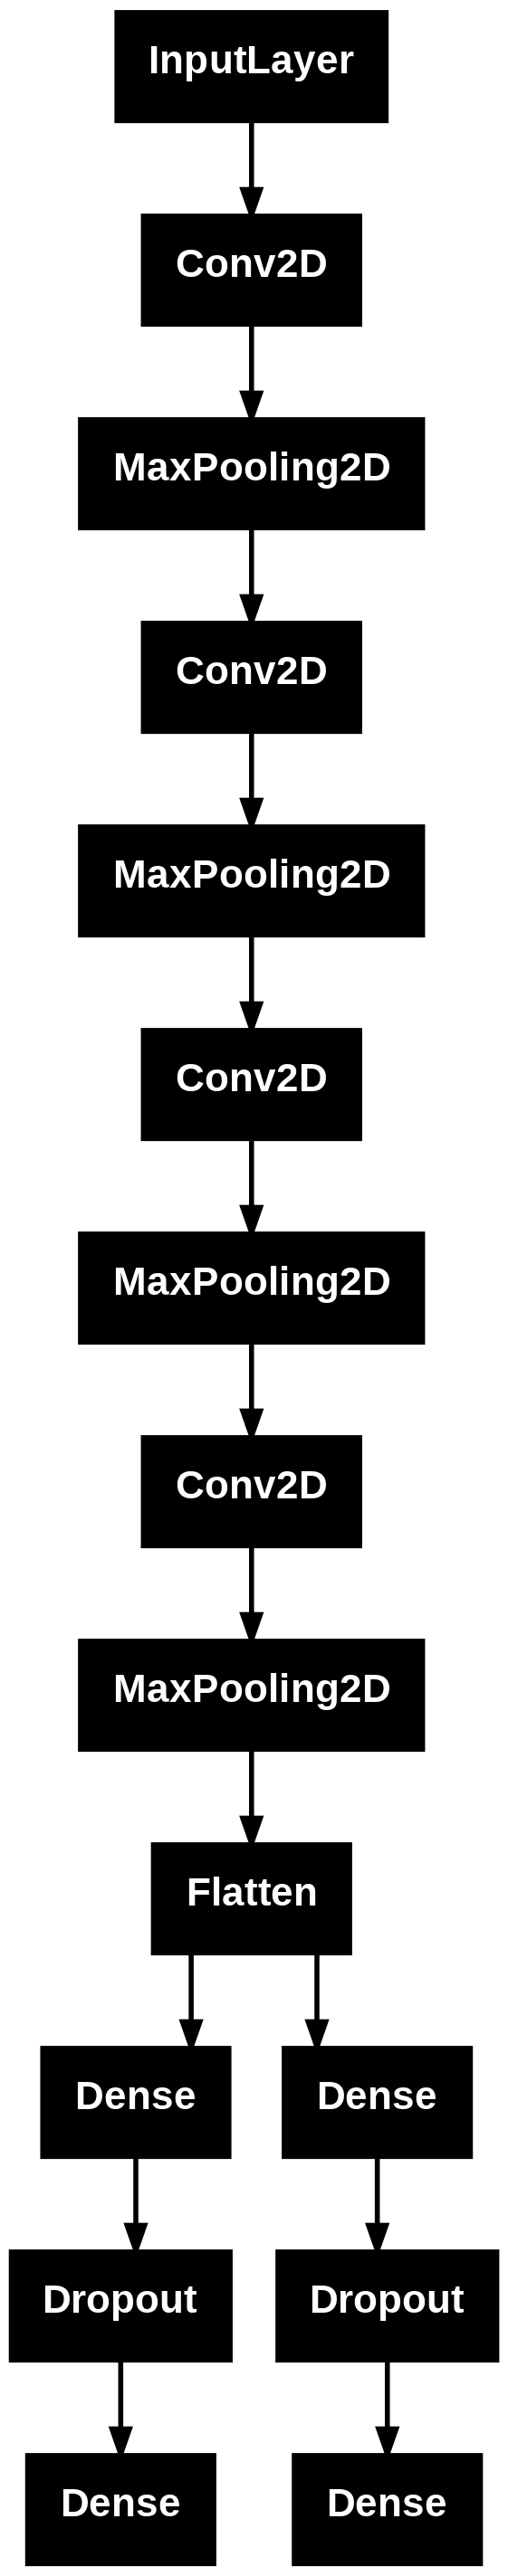

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [29]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 772s 1s/step - age_out_loss: 16.6116 - age_out_mae: 16.6116 - gender_out_accuracy: 0.5160 - gender_out_loss: 0.7133 - loss: 17.3248 - val_age_out_loss: 11.2497 - val_age_out_mae: 11.2788 - val_gender_out_accuracy: 0.7292 - val_gender_out_loss: 0.5435 - val_loss: 11.8235
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - age_out_loss: 11.6512 - age_out_mae: 11.6512 - gender_out_accuracy: 0.7379 - gender_out_loss: 0.5311 - loss: 12.1823 - val_age_out_loss: 9.6606 - val_age_out_mae: 9.6791 - val_gender_out_accuracy: 0.7881 - val_gender_out_loss: 0.4483 - val_loss: 10.1286
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - age_out_loss: 9.8825 - age_out_mae: 9.8825 - gender_out_accuracy: 0.7850 - gender_out_loss: 0.4636 - loss: 10.3462 - val_age_out_loss: 8.6157 - val_age_out_mae: 8.6232 - val_gender_out_accuracy: 0.8020 - val_gender_out_loss: 0.4085 - val_loss: 9.0332
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 781s 1s/step - age_out_loss: 8.759

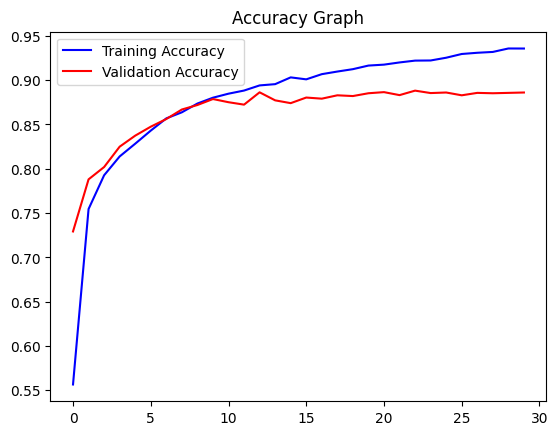

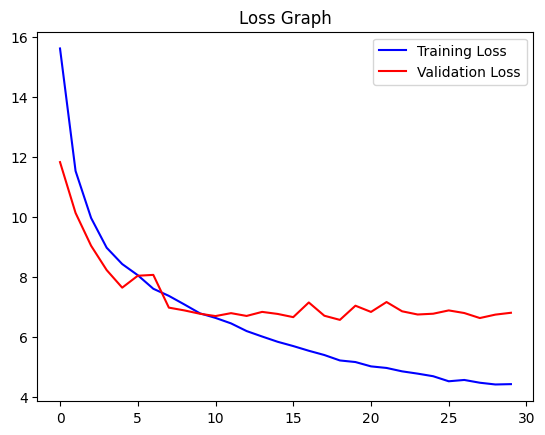

In [30]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

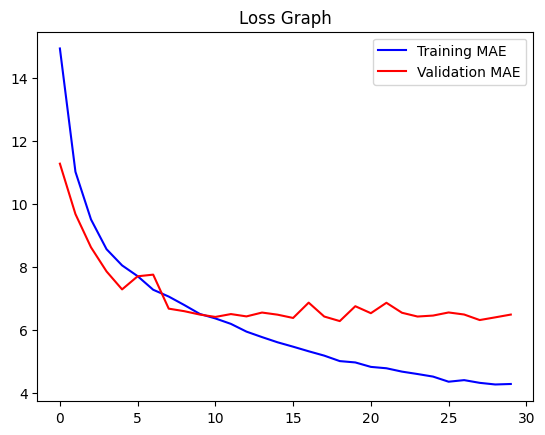

In [31]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted Gender: Female Predicted Age: 80


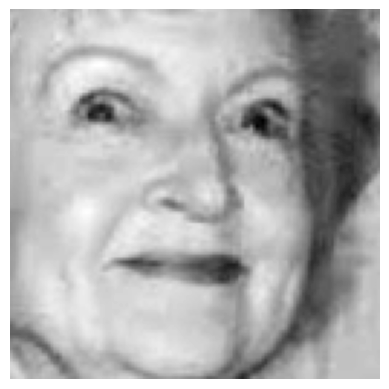

In [32]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gender: Male Predicted Age: 47


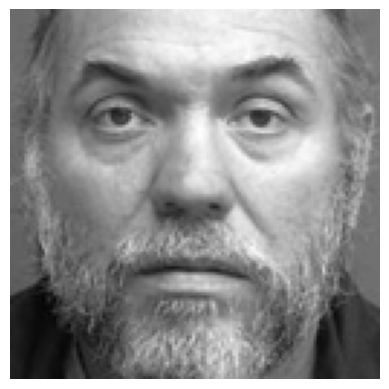

In [33]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Gender: Male Predicted Age: 22


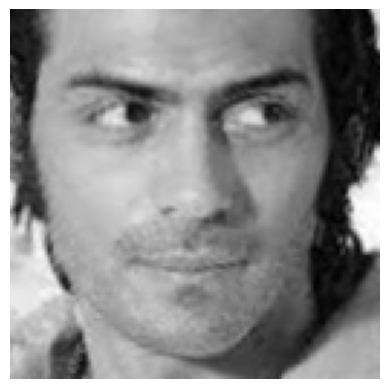

In [34]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Gender: Male Predicted Age: 31


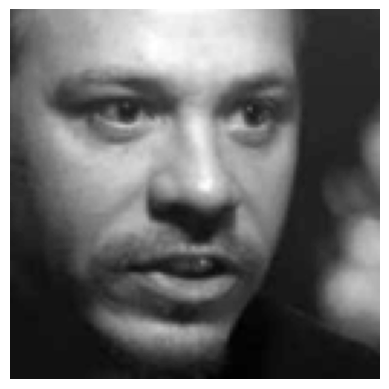

In [35]:
image_index = 150
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [36]:
# Save the trained model in Keras HDF5 format
model.save('/content/drive/MyDrive/Gender_Age_model.keras')
